# Preliminary PDM tests

In [1]:
import os
from os import path

import numpy as np
from scipy.io import wavfile
from scipy.signal import resample
import matplotlib.pyplot as plt

TIDIGITS_TRAIN_DIR = path.expanduser('~/Data/TIDIGITS/isolated_digits_ti_train')

In [2]:
# adapted from: https://gist.github.com/jeanminet/2913ca7a87e96296b27e802575ad6153
def pdm(x):
    n = len(x)
    y = np.zeros(n)
    error = np.zeros(n+1)    
    for i in range(n):
        y[i] = 1 if x[i] >= error[i] else 0
        error[i+1] = y[i] - x[i] + error[i]
    return y, error[:n]

In [3]:
def get_pdm_samples(samples, pdm_factor):
    n_pdm_samples = int(np.round(len(samples) * pdm_factor))
    upsampled_samples = resample(samples, n_pdm_samples)
    pdm_samples, pdm_error = pdm(upsampled_samples)
    return pdm_samples, upsampled_samples

## Basic test with constructed sinusoid signal

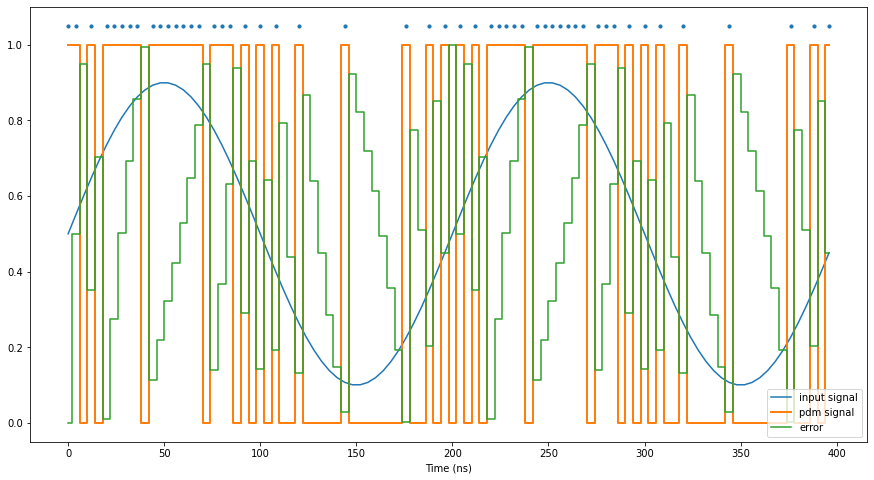

In [4]:
n = 100
fclk = 250e6 # clock frequency (Hz)
t = np.arange(n) / fclk
f_sin = 5e6 # sine frequency (Hz)

x = 0.5 + 0.4 * np.sin(2*np.pi*f_sin*t)
y, error = pdm(x)
indexes = np.where(y==1)[0]

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(1e9*t, x, label='input signal')
ax.step(1e9*t, y, label='pdm signal',  linewidth=2.0, where='mid')
ax.step(1e9*t, error, label='error', where='mid')
ax.scatter(1e9*t[indexes], np.ones(len(indexes))+0.05, s=10, c='C0')
ax.set_xlabel('Time (ns)')
ax.set_ylim(-0.05, 1.1)
ax.legend(loc='lower right')
plt.show()

## Test with real speech signal

In [5]:
wav_files = []
for root, d_names, f_names in os.walk(TIDIGITS_TRAIN_DIR):
    wav_files.extend([path.join(root, f) for f in f_names if f.lower().endswith('wav')])    
n_files = len(wav_files)

In [6]:
file_index = np.random.randint(n_files)
wav_file = wav_files[file_index]
sample_rate, samples = wavfile.read(wav_files[file_index])
samples = samples.astype(np.float32)
samples -= np.min(samples)
samples /= np.max(samples)
duration = len(samples) / sample_rate

959998.7793141068


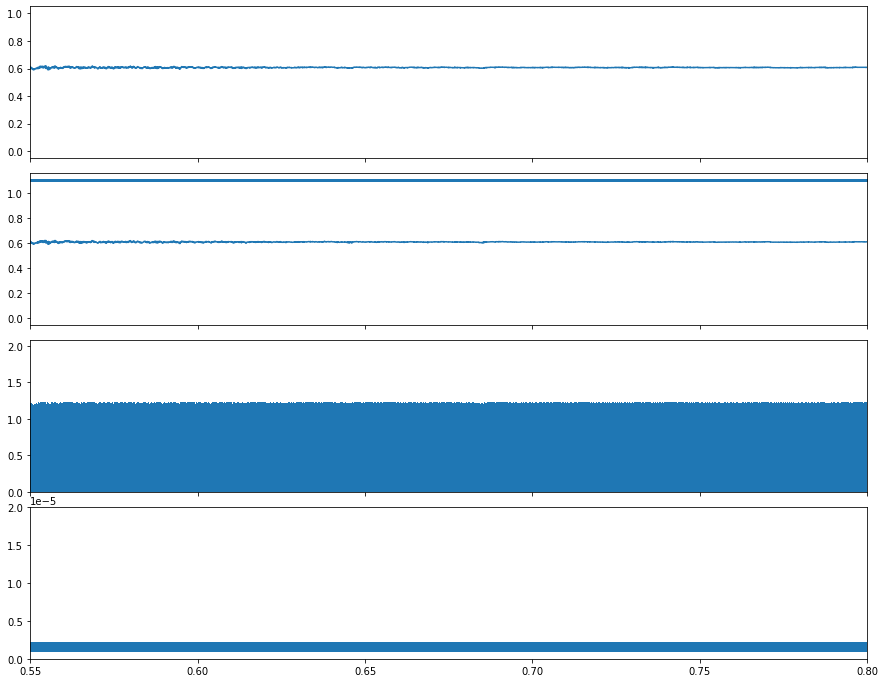

In [7]:
pdm_factor = 48
pdm_sample_rate = sample_rate * pdm_factor
pdm_samples, upsampled_samples = get_pdm_samples(samples, pdm_factor)

fig, axes = plt.subplots(4, 1, figsize=(15, 12), gridspec_kw=dict(hspace=0.1),
                         sharex=True)

ts = np.linspace(0, duration, len(samples))
axes[0].plot(ts, samples)

ts = np.linspace(0, duration, len(upsampled_samples))
axes[1].plot(ts, upsampled_samples)

indexes = np.where(pdm_samples)[0]
axes[1].scatter(ts[indexes], np.ones(len(indexes))+0.1, s=1)

axes[2].hist(ts[indexes], range=(0, duration), bins=4096, density=True)

diffs = np.diff(ts[indexes])
ts = np.linspace(0, duration, len(diffs))
axes[3].plot(ts, diffs)

print(1/np.min(diffs))

axes[3].set_ylim(0, 0.00002)
#axes[3].set_xlim(0.6, 0.601)
axes[3].set_xlim(0.55, 0.8)

plt.show()

## Plot spectral content of speech signal before / after PDM modulation

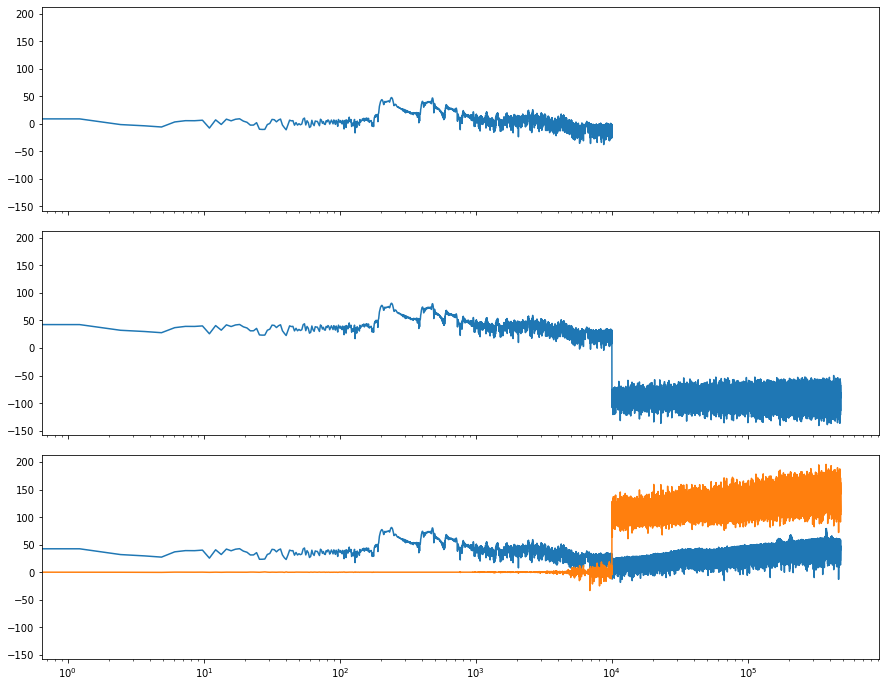

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12), gridspec_kw=dict(hspace=0.1),
                         sharey=True, sharex=True)

fft_samples = 20*np.log10(np.abs(np.fft.rfft(samples)))
fft_upsampled_samples = 20*np.log10(np.abs(np.fft.rfft(upsampled_samples)))
fft_pdm_samples = 20*np.log10(np.abs(np.fft.rfft(pdm_samples)))

fft_samples_freqs = np.linspace(0, sample_rate/2, len(fft_samples))
fft_pdm_samples_freqs = np.linspace(0, pdm_sample_rate/2, len(fft_pdm_samples))

ts = np.linspace(0, duration, len(samples))
axes[0].plot(fft_samples_freqs, fft_samples)
axes[1].plot(fft_pdm_samples_freqs, fft_upsampled_samples)
axes[2].plot(fft_pdm_samples_freqs, fft_pdm_samples)
axes[2].plot(fft_pdm_samples_freqs, fft_pdm_samples-fft_upsampled_samples)

axes[0].semilogx()
axes[1].semilogx()
axes[2].semilogx()

plt.show()

## Explore effect of PDM factor (pdm_sample_rate / input_sample_rate)

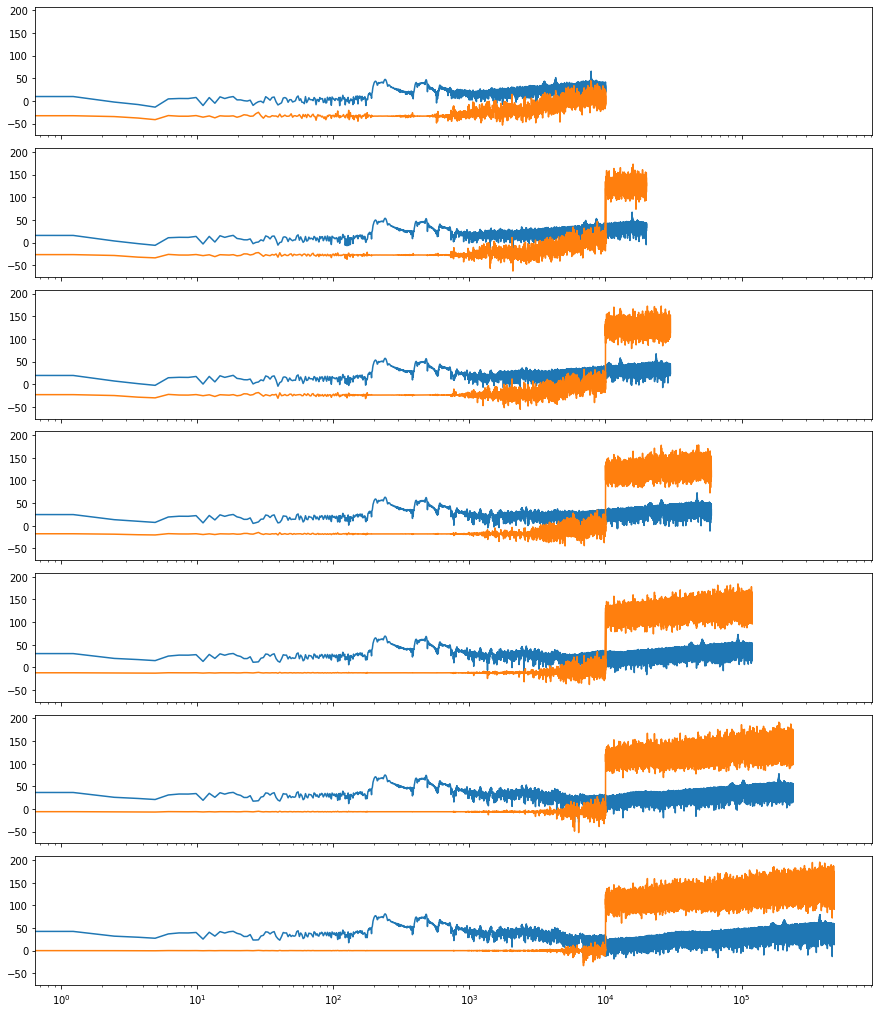

In [9]:
pdm_factors = [1, 2, 3, 6, 12, 24, 48]

fft_samples = 20*np.log10(np.abs(np.fft.rfft(samples)))
fft_upsampled_samples = 20*np.log10(np.abs(np.fft.rfft(upsampled_samples)))

fig, axes = plt.subplots(len(pdm_factors), 1, figsize=(15, 18), gridspec_kw=dict(hspace=0.1),
                         sharey=True, sharex=True)

for i, pdm_factor in enumerate(pdm_factors):
    pdm_samples, _ = get_pdm_samples(samples, pdm_factor)
    fft_pdm_samples = 20*np.log10(np.abs(np.fft.rfft(pdm_samples)))
    sr = sample_rate * pdm_factor
    freqs = np.linspace(0, sr/2, len(fft_pdm_samples))

    axes[i].plot(freqs, fft_pdm_samples)
    axes[i].plot(freqs, fft_pdm_samples-fft_upsampled_samples[:len(fft_pdm_samples)])
    axes[i].semilogx()

plt.show()

## Explore spectral content of PDM signal with high-resolution Chirp-Z transform

In [3]:
import czt

In [4]:
# Time data
dt = 1 / pdm_sample_rate
t = np.arange(0, duration, dt)
N = len(pdm_samples)
df = pdm_sample_rate / N

print("Sampling period:    {:5.2f} ms".format(dt * 1e3))
print("Sampling frequency: {:5.2f} kHz".format(pdm_sample_rate / 1e3))
print("Nyquist frequency:  {:5.2f} kHz".format(pdm_sample_rate / 2 / 1e3))
print("Number of points:   {:5d}".format(N))

NameError: name 'pdm_sample_rate' is not defined

In [12]:
start_time = 0.5
end_time = 0.6
start = int(start_time * sample_rate)
end = int(end_time * sample_rate)
samples_trunc = samples[start:end]
duration = len(samples_trunc) / sample_rate
'''samples_trunc = samples.copy()
duration = len(samples_trunc) / sample_rate'''

samples_t = np.arange(0, duration, 1/sample_rate)

pdm_factor = 48
pdm_samples,_ = get_pdm_samples(samples_trunc, pdm_factor)
pdm_samples_zero_mean = pdm_samples - 0.5
pdm_sample_rate = sample_rate * pdm_factor
pdm_dt = 1 / pdm_sample_rate
pdm_t = np.arange(0, duration, pdm_dt)

fft_pdm_samples = 20*np.log10(np.abs(np.fft.rfft(pdm_samples_zero_mean)))

freqs = np.linspace(0, pdm_sample_rate/2, len(fft_pdm_samples))

freq_zoom = np.linspace(100, 4000, 512)
#freq_zoom = np.arange(1700, 2800, 1.7 * df)
freq, sig_f = czt.time2freq(pdm_t, pdm_samples, freq_zoom)

rec_t, rec_pdm_samples = czt.freq2time(freq, sig_f, pdm_t)

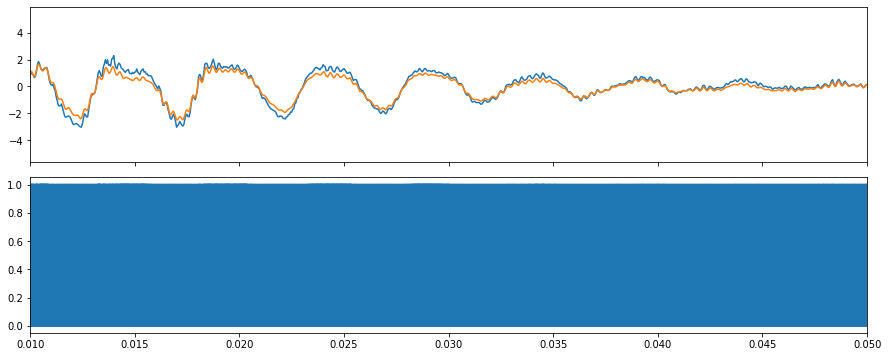

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw=dict(hspace=0.1), sharex=True)

def normalize(x):
    x = x - np.mean(x)
    #x /= np.sqrt(np.mean(x**2))
    x /= np.std(x)
    return x

axes[0].plot(samples_t, normalize(samples_trunc), c='C0')
axes[0].plot(rec_t, normalize(rec_pdm_samples.real), c='C1')

axes[1].plot(pdm_t, pdm_samples)

axes[1].set_xlim(0.01, 0.05)

plt.show()

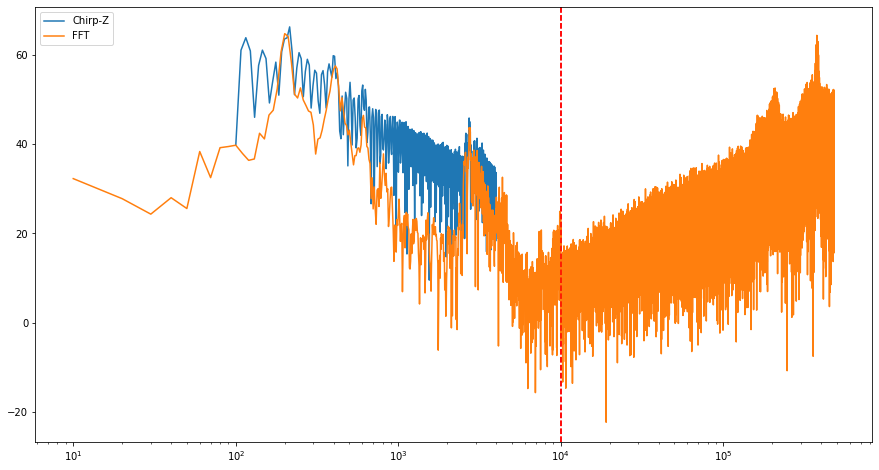

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), gridspec_kw=dict(hspace=0.1), sharex=True)

mark_freq = 10000

#ax = axes[0]
#ax.plot(freq[N//2:], 20*np.log10(np.abs(sig_f[N//2:])))
ax.plot(freq_zoom, 20*np.log10(np.abs(sig_f)), label='Chirp-Z')
ax.semilogx()
ax.axvline(mark_freq, c='r', linestyle='--')

#ax = axes[1]
ax.plot(freqs[1:], fft_pdm_samples[1:], label='FFT')
ax.semilogx()
ax.axvline(mark_freq, c='r', linestyle='--')

ax.legend(loc='upper left')
#ax = axes[2]
plt.show()